In [34]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
headers = pd.read_csv('./data/headers.csv', header=None)
train = pd.read_csv('./data/kddcup_train_10_percent', header=None)
test = pd.read_csv('./data/kddcup_test_labeled',header=None)

In [4]:
headers = headers.loc[:,0].tolist()
headers.append('type_attack')

In [5]:
train.columns = headers
test.columns = headers

## Data Exploration

In [6]:
train.shape
test.shape

(494021, 42)

(311029, 42)

In [7]:
# There are duplicate rows

train.duplicated().value_counts()
test.duplicated().value_counts()

True     348435
False    145586
dtype: int64

True     233738
False     77291
dtype: int64

In [8]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

train.duplicated().value_counts()
test.duplicated().value_counts()

False    145586
dtype: int64

False    77291
dtype: int64

In [9]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [10]:
# Type of columns

cat_cols = [c for c in train.select_dtypes(include=['object']).columns.tolist() if c != 'type_attack']
num_cols = [c for c in train.columns.tolist()[:-1] if c not in cat_cols]

In [11]:
# Remove dot in label

train.type_attack = train.type_attack.map(lambda x: str(x)[:-1])
test.type_attack = test.type_attack.map(lambda x: str(x)[:-1])

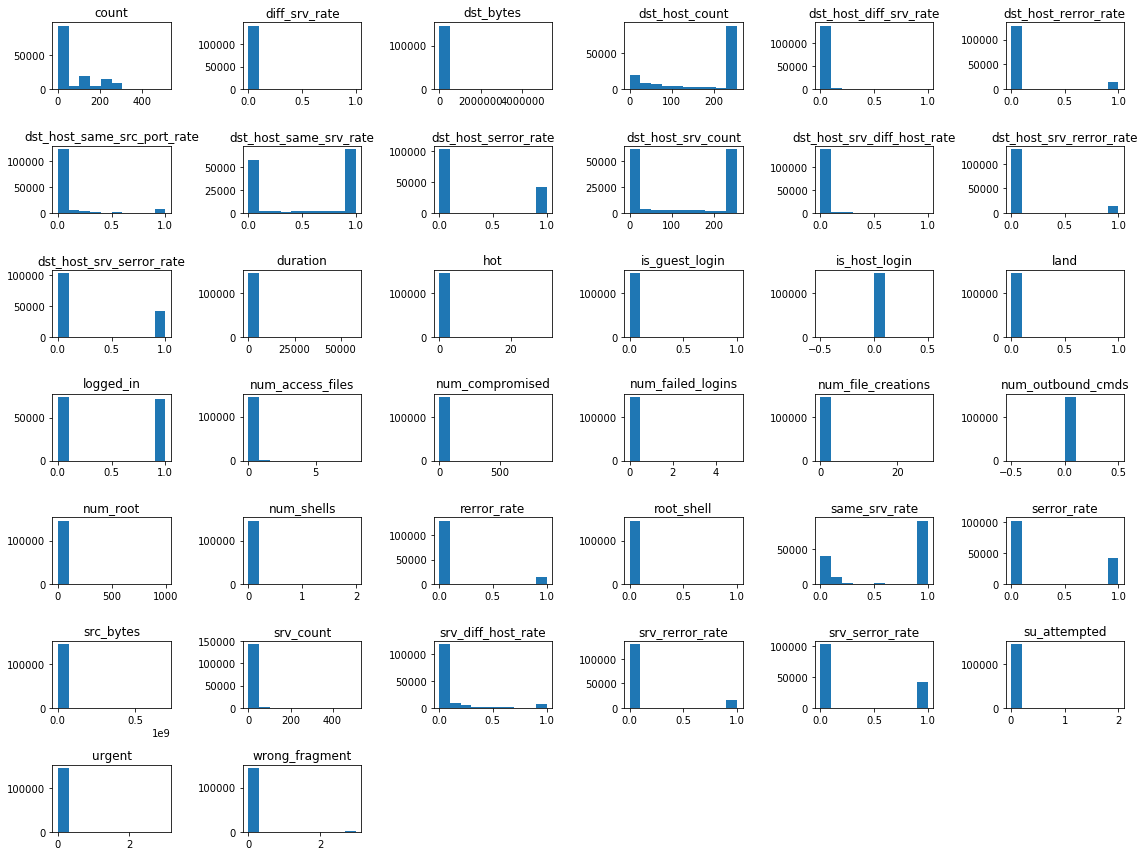

In [90]:
f, axs = plt.subplots(figsize=(16,12))
train.hist(ax=axs, grid=False);
f.tight_layout(w_pad=0.5);

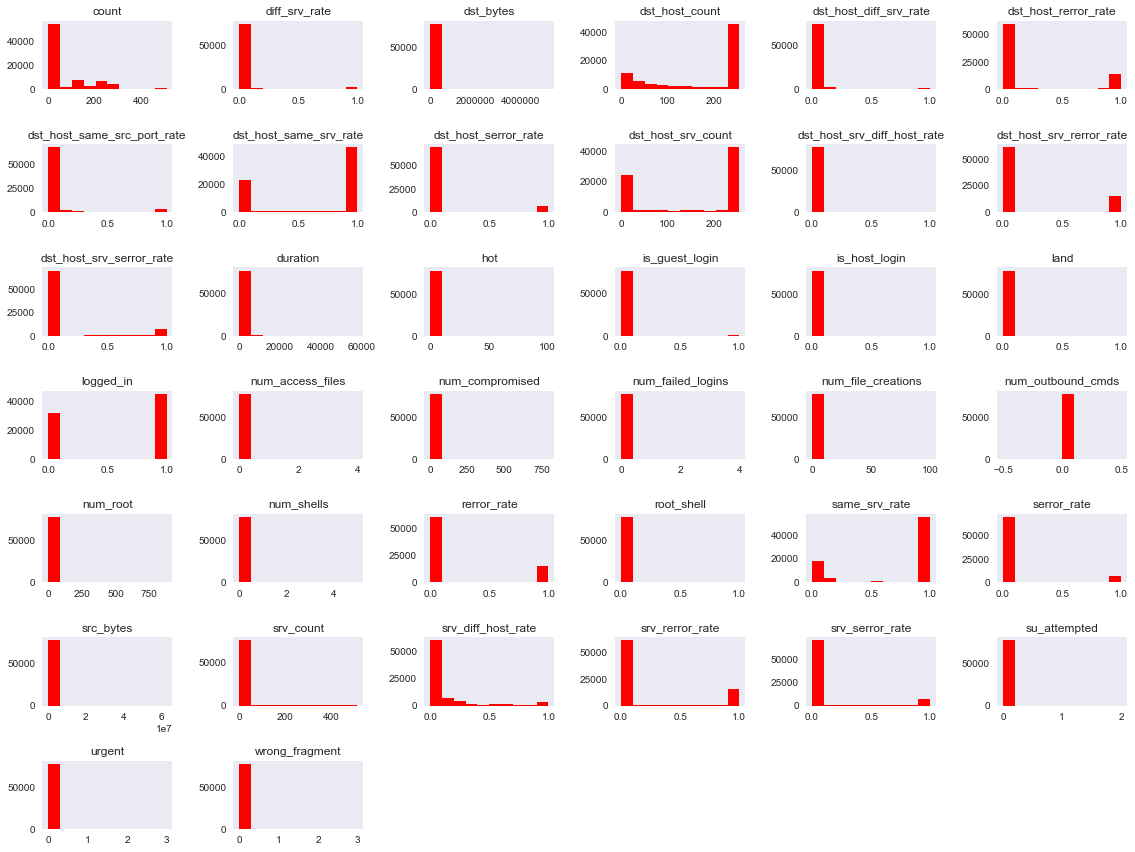

In [134]:
f, axs = plt.subplots(figsize=(16,12))
test.hist(ax=axs, grid=False, color='red');
f.tight_layout(w_pad=0.5);

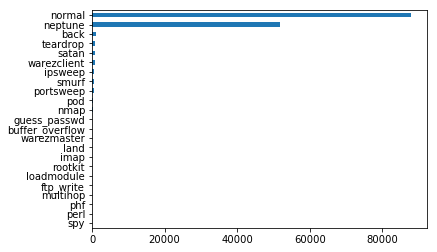

In [104]:
train.type_attack.value_counts().sort_values().plot(kind='barh');

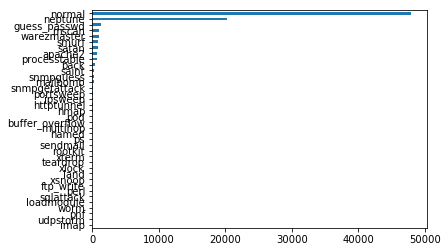

In [102]:
test.type_attack.value_counts().sort_values().plot(kind='barh');

## Feature Engineering

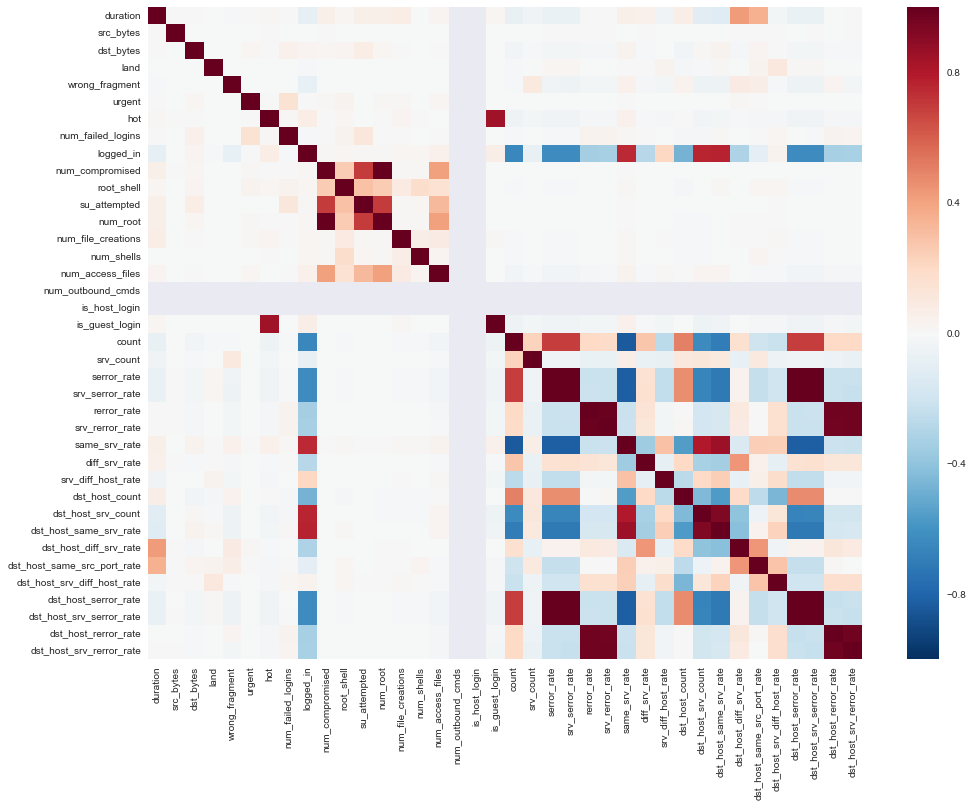

In [120]:
f, axs = plt.subplots(figsize=(16,12))
sns.heatmap(train.corr());

In [12]:
def get_uniques(df):
    one_val = []
    for c in df.columns:
        n_vals = df[c].value_counts().shape[0]
        if n_vals == 1:
            one_val.append(c)
    return one_val

print get_uniques(train)
print get_uniques(test)

['num_outbound_cmds', 'is_host_login']
['num_outbound_cmds']


In [13]:
# Get X and Y

x_train = train.drop('type_attack', axis=1)
y_train = train['type_attack']

x_test = test.drop('type_attack', axis=1)
y_test = test['type_attack']

In [14]:
y_train = y_train.map(lambda x: 0 if x == 'normal' else 1)
y_test = y_test.map(lambda x: 0 if x == 'normal' else 1)

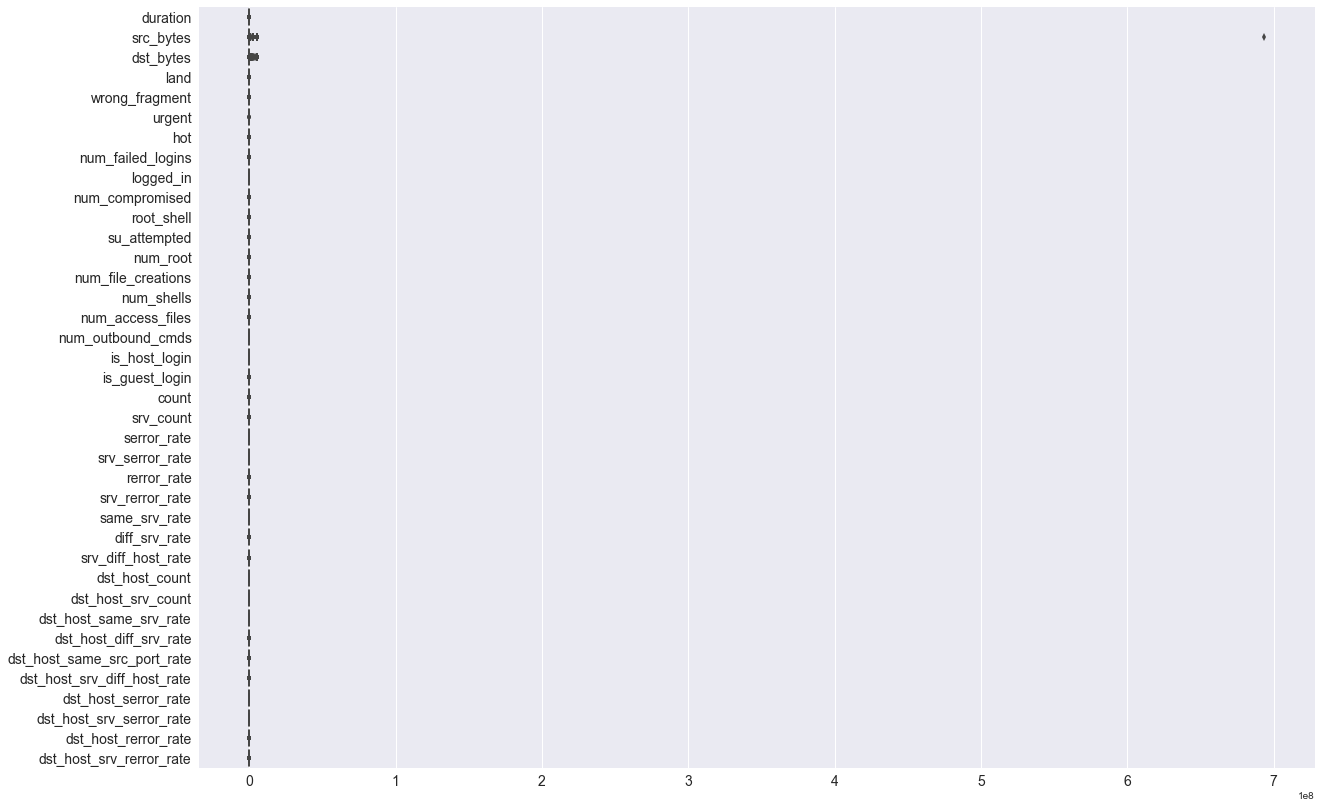

In [164]:
f, axs = plt.subplots(figsize=(20,14))
sns.boxplot(data=x_train, ax=axs, orient='h');
axs.tick_params(labelsize=14);

In [15]:
x_train.src_bytes[x_train.src_bytes==693375640] = x_train.src_bytes.median()

C:\Users\JERSON\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


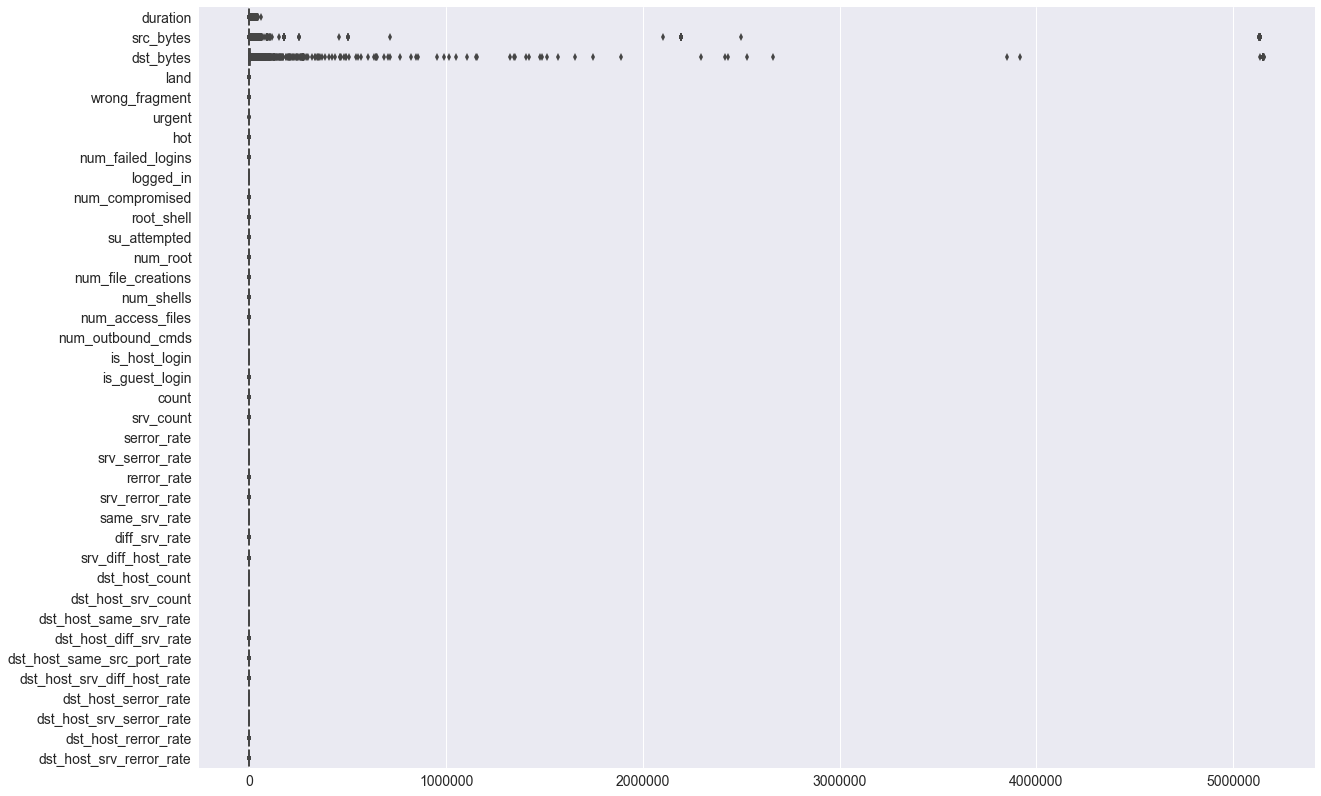

In [212]:
f, axs = plt.subplots(figsize=(20,14))
sns.boxplot(data=x_train, ax=axs, orient='h');
axs.tick_params(labelsize=14);

In [16]:
# 3 types of df 

# pca3 
# pca3 w scaler 
# pca3 w cluster feats

from sklearn.cluster import KMeans
from collections import Counter
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [17]:
dm1 = pd.get_dummies(x_train[cat_cols[0]], prefix=cat_cols[0])
dm2 = pd.get_dummies(x_train[cat_cols[1]], prefix=cat_cols[0])
dm3 = pd.get_dummies(x_train[cat_cols[2]], prefix=cat_cols[0])
x_train_he = pd.concat([x_train, dm1, dm2, dm3], axis=1)
x_train_he.drop(cat_cols, inplace=True, axis=1)

In [18]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(x_train_he)

columns = ['pca{}'.format(i+1) for i in range(pca_result.shape[1])]
x_train_pca = pd.DataFrame(pca_result, columns=columns)

print 'Explained variation per principal component : {}'.format(np.sum(pca.explained_variance_ratio_))

Explained variation per principal component : 0.999997785771


In [19]:
pca = PCA(n_components=3)
x_scaler = RobustScaler().fit_transform(x_train_he)
pca_result = pca.fit_transform(x_scaler)

columns = ['pca{}'.format(i+1) for i in range(pca_result.shape[1])]
x_train_pca_scaler = pd.DataFrame(pca_result, columns=columns)

print 'Explained variation per principal component : {}'.format(np.sum(pca.explained_variance_ratio_))

Explained variation per principal component : 0.999933022305


In [36]:
km = KMeans(n_clusters=5, random_state=0)
km = km.fit(x_scaler)

dc1 = x_train_he.apply(
    lambda x: np.power(
        np.array(x)-km.cluster_centers_[0], 2), axis=1
).apply(lambda x: np.sqrt(np.sum(x)), axis=1)

dc2 = x_train_he.apply(
    lambda x: np.power(
        np.array(x)-km.cluster_centers_[1], 2), axis=1
).apply(lambda x: np.sqrt(np.sum(x)), axis=1)

dc3 = x_train_he.apply(
    lambda x: np.power(
        np.array(x)-km.cluster_centers_[2], 2), axis=1
).apply(lambda x: np.sqrt(np.sum(x)), axis=1)

dc4 = x_train_he.apply(
    lambda x: np.power(
        np.array(x)-km.cluster_centers_[3], 2), axis=1
).apply(lambda x: np.sqrt(np.sum(x)), axis=1)

dc5 = x_train_he.apply(
    lambda x: np.power(
        np.array(x)-km.cluster_centers_[4], 2), axis=1
).apply(lambda x: np.sqrt(np.sum(x)), axis=1)

columns = ['dC{}'.format(i+1) for i in range(5)]
df_km = pd.concat([dc1, dc2, dc3, dc4, dc5], axis=1)
df_km.columns = columns

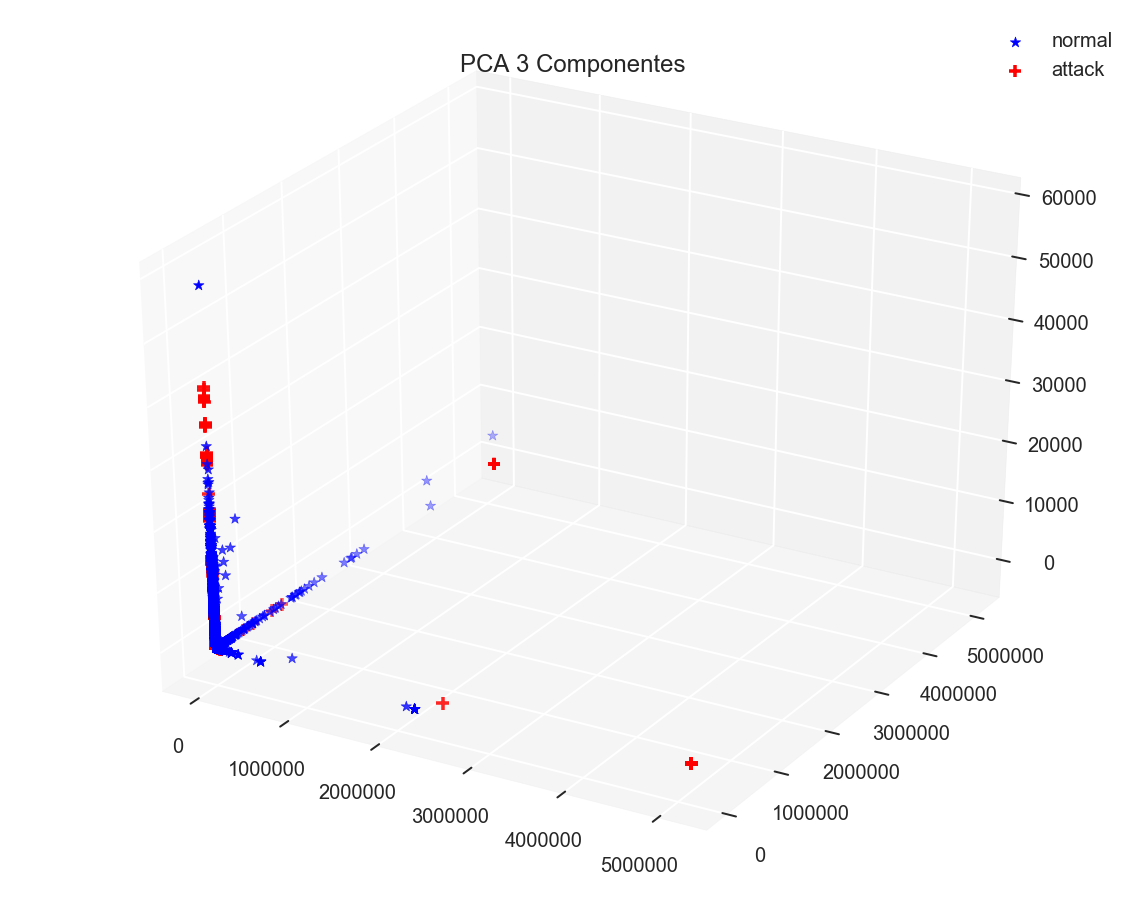

In [35]:
from mpl_toolkits.mplot3d import Axes3D

f = plt.figure(figsize=(10,8))
ax = f.add_subplot(111, projection='3d')

pca_norm = x_train_pca[y_train==0]
x1 = pca_norm.pca1
y1 = pca_norm.pca2
z1 = pca_norm.pca3

pca_attack = x_train_pca[y_train==1]
x2 = pca_attack.pca1
y2 = pca_attack.pca2
z2 = pca_attack.pca3

ax.scatter(x1, y1, z1, c='b', marker='*', s=30, label='normal');
ax.scatter(x2, y2, z2, c='r', marker='+', s=40, label='attack');
ax.legend();
ax.set_title('PCA 3 Componentes');
ax.set_facecolor('white');

In [37]:
#x_test

dm1 = pd.get_dummies(x_test[cat_cols[0]], prefix=cat_cols[0])
dm2 = pd.get_dummies(x_test[cat_cols[1]], prefix=cat_cols[0])
dm3 = pd.get_dummies(x_test[cat_cols[2]], prefix=cat_cols[0])
x_test_he = pd.concat([x_test, dm1, dm2, dm3], axis=1)
x_test_he.drop(cat_cols, inplace=True, axis=1)

pca = PCA(n_components=3)
pca_result = pca.fit_transform(x_test_he)

columns = ['pca{}'.format(i+1) for i in range(pca_result.shape[1])]
x_test_pca = pd.DataFrame(pca_result, columns=columns)

print 'Explained variation per principal component : {}'.format(np.sum(pca.explained_variance_ratio_))

Explained variation per principal component : 0.999999450505


In [38]:
pca = PCA(n_components=3)
x_scaler = RobustScaler().fit_transform(x_test_he)
pca_result = pca.fit_transform(x_scaler)

columns = ['pca{}'.format(i+1) for i in range(pca_result.shape[1])]
x_test_pca_scaler = pd.DataFrame(pca_result, columns=columns)

print 'Explained variation per principal component : {}'.format(np.sum(pca.explained_variance_ratio_))

Explained variation per principal component : 0.999786785033


In [39]:
km = KMeans(n_clusters=5, random_state=0)
km = km.fit(x_scaler)

dc1 = x_test_he.apply(
    lambda x: np.power(
        np.array(x)-km.cluster_centers_[0], 2), axis=1
).apply(lambda x: np.sqrt(np.sum(x)), axis=1)

dc2 = x_test_he.apply(
    lambda x: np.power(
        np.array(x)-km.cluster_centers_[1], 2), axis=1
).apply(lambda x: np.sqrt(np.sum(x)), axis=1)

dc3 = x_test_he.apply(
    lambda x: np.power(
        np.array(x)-km.cluster_centers_[2], 2), axis=1
).apply(lambda x: np.sqrt(np.sum(x)), axis=1)

dc4 = x_test_he.apply(
    lambda x: np.power(
        np.array(x)-km.cluster_centers_[3], 2), axis=1
).apply(lambda x: np.sqrt(np.sum(x)), axis=1)

dc5 = x_test_he.apply(
    lambda x: np.power(
        np.array(x)-km.cluster_centers_[4], 2), axis=1
).apply(lambda x: np.sqrt(np.sum(x)), axis=1)

columns = ['dC{}'.format(i+1) for i in range(5)]
df_km_test = pd.concat([dc1, dc2, dc3, dc4, dc5], axis=1)
df_km_test.columns = columns

## Modeling

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn import metrics

import time
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

C:\Users\JERSON\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [41]:
def get_auc_model(x_data, y_data, clf):
    results = []
    skf = StratifiedKFold(y_data, n_folds=5, random_state=0)
    results = cross_val_score(clf, x_data, y_data, cv=skf, scoring='roc_auc')
    return results

In [59]:
def plot_results(results, n, names):
    f, axs = plt.subplots(n, 1)
    for i, ax in enumerate(axs):
        b = ax.boxplot(results[i], vert=False, patch_artist=True)
        ax.set_yticklabels(names, fontsize=10)
        ax.set_xlabel('AUC score cv')
        ax.set_title('Baseline')
        colors = ['teal', 'tomato', 'gold']
        for patch, color in zip(b['boxes'], colors):
            patch.set_facecolor(color)
    f.tight_layout(w_pad=1)

AUC LR: 69.632% (14.572%)
AUC KN: 98.284% (2.737%)
AUC NB: 75.034% (6.863%)
----------------------------------------------------------------------------------------------------
AUC LR: 87.137% (5.280%)
AUC KN: 98.091% (2.668%)
AUC NB: 74.319% (7.058%)
----------------------------------------------------------------------------------------------------


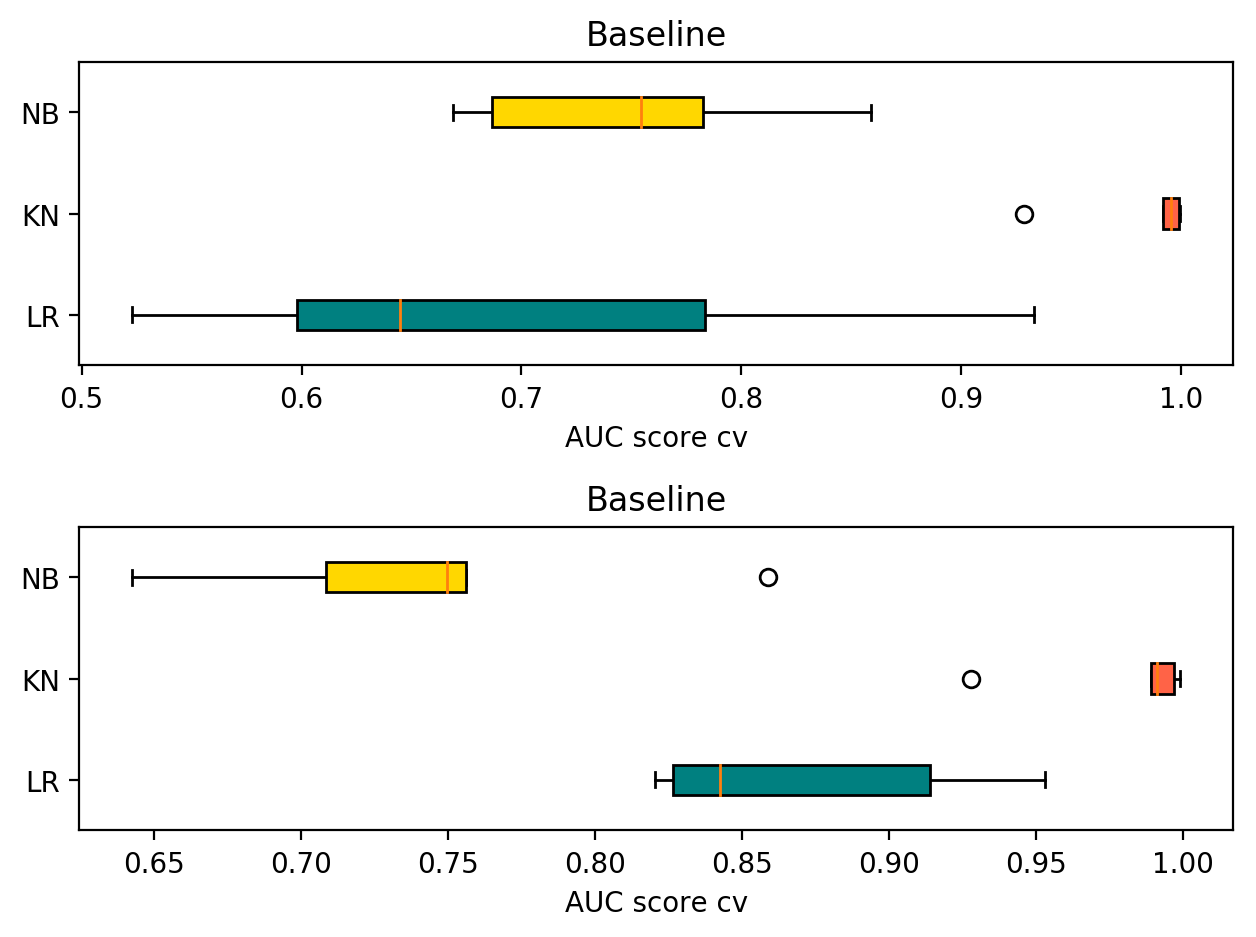

In [60]:
# Base Line 

results = []
models = []
models.append(('LR', LogisticRegression()))
models.append(('KN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))

datasets = [x_train_pca, pd.concat([x_train_pca, df_km], axis=1)]

for data in datasets:
    dresults = []

    for name, model in models:
        t1 = time.time()
        res = get_auc_model(data, y_train, model)
        dresults.append(res)
        #print 'CV {} done! Time elapsed: {} seconds'.format(name, time.time()-t1)
        print("AUC %s: %.3f%% (%.3f%%)") % (name, res.mean()*100.0, res.std()*100.0)
    print '-' * 100
    results.append(dresults)
    
plot_results(results, len(datasets), [i[0] for i in models])

In [201]:
def plot_results(results, n, names):
    f, axs = plt.subplots(n, 1)
    for i, ax in enumerate(axs):
        b = ax.boxplot(results[i], vert=False, patch_artist=True)
        ax.set_yticklabels(names, fontsize=10)
        ax.set_xlabel('AUC score cv')
        ax.set_title('Ensemble')
        colors = ['teal', 'tomato', 'gold', 'indigo', 'khaki']
        for patch, color in zip(b['boxes'], colors):
            patch.set_facecolor(color)
    f.tight_layout(w_pad=1)

AUC DT: 98.679% (1.666%)
AUC RF: 99.137% (1.411%)
AUC GB: 99.923% (0.079%)
AUC AD: 99.803% (0.166%)
AUC ET: 99.053% (1.618%)
----------------------------------------------------------------------------------------------------
AUC DT: 98.645% (1.638%)
AUC RF: 99.092% (1.585%)
AUC GB: 99.877% (0.168%)
AUC AD: 99.714% (0.392%)
AUC ET: 99.087% (1.160%)
----------------------------------------------------------------------------------------------------


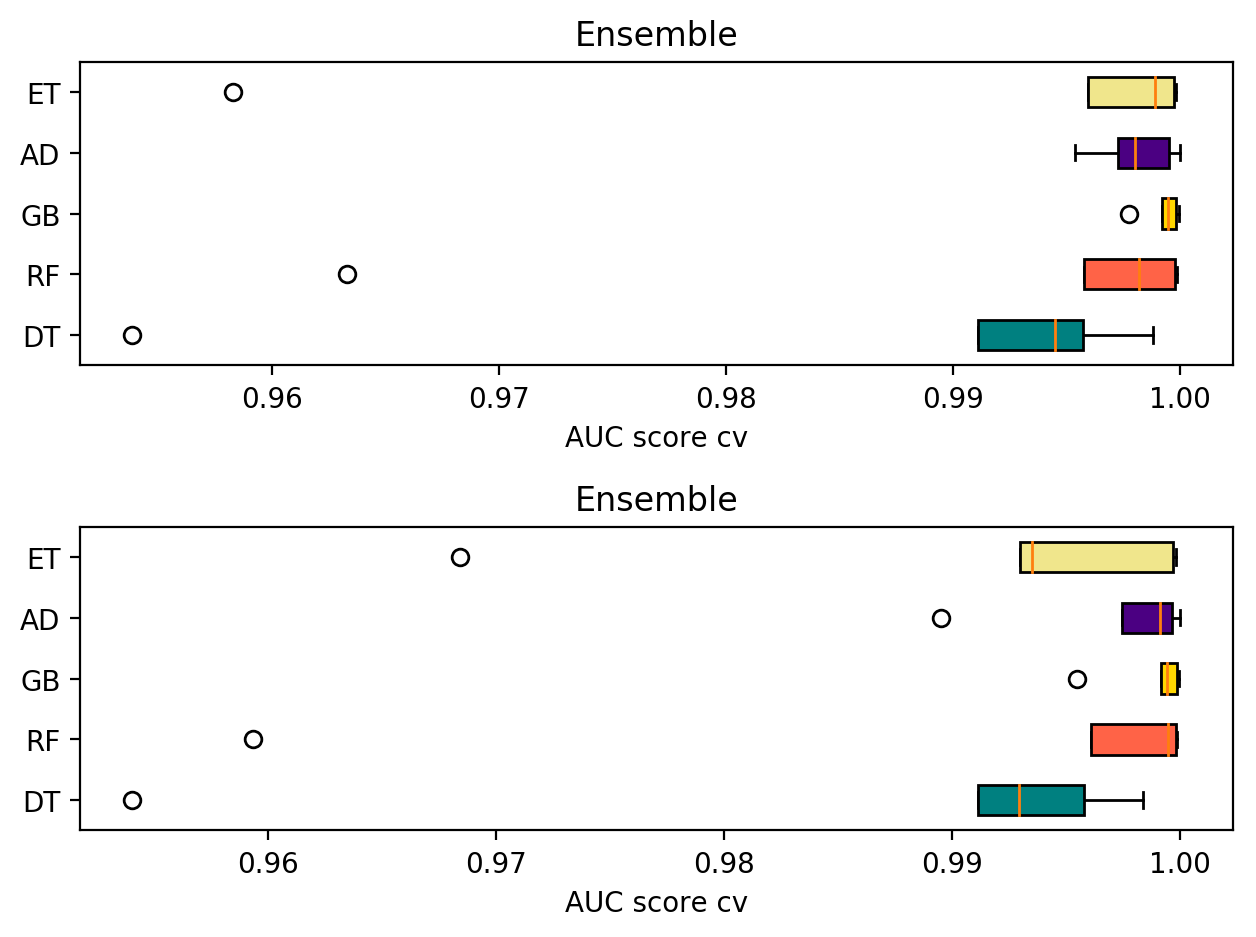

In [202]:
# Tree based

results = []
models = []
models.append(('DT' , DecisionTreeClassifier()))
models.append(('RF' , RandomForestClassifier()))
models.append(('GB' , GradientBoostingClassifier()))
models.append(('AD' , AdaBoostClassifier()))
models.append(('ET' , ExtraTreesClassifier()))

datasets = [x_train_pca, pd.concat([x_train_pca, df_km], axis=1)]

for data in datasets:
    dresults = []

    for name, model in models:
        t1 = time.time()
        res = get_auc_model(data, y_train, model)
        dresults.append(res)
        #print 'CV {} done! Time elapsed: {} seconds'.format(name, time.time()-t1)
        print("AUC %s: %.3f%% (%.3f%%)") % (name, res.mean()*100.0, res.std()*100.0)
    print '-' * 100
    results.append(dresults)
    
plot_results(results, len(datasets), [i[0] for i in models])

AUC DT: 98.669% (1.592%)
AUC RF: 99.127% (1.218%)
AUC GB: 99.879% (0.163%)
AUC AD: 99.714% (0.392%)
AUC ET: 99.152% (1.135%)
----------------------------------------------------------------------------------------------------
AUC DT: 97.571% (3.400%)
AUC RF: 99.113% (1.318%)
AUC GB: 99.835% (0.147%)
AUC AD: 99.527% (0.539%)
AUC ET: 99.126% (1.243%)
----------------------------------------------------------------------------------------------------


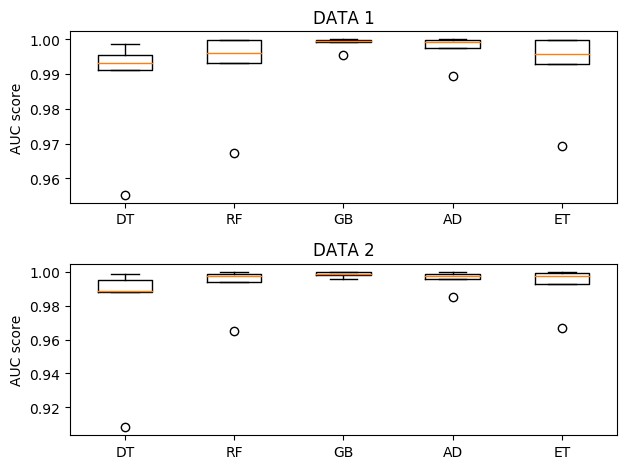

In [171]:
results = []
models = []
models.append(('DT' , DecisionTreeClassifier()))
models.append(('RF' , RandomForestClassifier()))
models.append(('GB' , GradientBoostingClassifier()))
models.append(('AD' , AdaBoostClassifier()))
models.append(('ET' , ExtraTreesClassifier()))

datasets = [pd.concat([x_train_pca, df_km], axis=1), pd.concat([x_train_pca_scaler, df_km], axis=1)]

for data in datasets:
    dresults = []

    for name, model in models:
        t1 = time.time()
        res = get_auc_model(data, y_train, model)
        dresults.append(res)
        #print 'CV {} done! Time elapsed: {} seconds'.format(name, time.time()-t1)
        print("AUC %s: %.3f%% (%.3f%%)") % (name, res.mean()*100.0, res.std()*100.0)
    print '-' * 100
    results.append(dresults)
    
plot_results(results, len(datasets), [i[0] for i in models])

In [66]:
# XG, LGBM, CAT

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

## XGboost

In [226]:
params_xgb = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'binary:logistic',
    'eval_metric':'auc'
}

In [68]:
xgb.cv(params_xgb, 
       xgb.DMatrix(x_train_pca, label=y_train), 
       num_boost_round=999,
       early_stopping_rounds=10, 
       nfold=5, 
       seed=0,
       metrics='auc')

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.998127,0.000368,0.998396,2.012107e-04
1,0.999089,0.000171,0.999132,1.713539e-04
2,0.999431,0.000081,0.999491,4.520000e-05
3,0.999476,0.000039,0.999543,5.520725e-05
4,0.999584,0.000043,0.999611,5.428665e-05
5,0.999629,0.000074,0.999667,1.511291e-05
6,0.999647,0.000076,0.999696,1.942782e-05
7,0.999655,0.000083,0.999709,2.430638e-05
8,0.999687,0.000086,0.999749,2.174029e-05
9,0.999733,0.000056,0.999786,1.939691e-05


In [69]:
xgb.cv(params_xgb, 
       xgb.DMatrix(pd.concat([x_train_pca, df_km], axis=1), label=y_train), 
       num_boost_round=999,
       early_stopping_rounds=10, 
       nfold=5, 
       seed=0,
       metrics='auc')

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.998079,0.000391,0.998399,0.000184
1,0.999148,0.000271,0.999207,0.000225
2,0.999443,0.000088,0.999512,0.000040
3,0.999459,0.000170,0.999575,0.000045
4,0.999550,0.000150,0.999639,0.000025
5,0.999629,0.000065,0.999679,0.000035
6,0.999648,0.000067,0.999704,0.000037
7,0.999681,0.000045,0.999742,0.000047
8,0.999716,0.000065,0.999781,0.000026
9,0.999739,0.000077,0.999812,0.000016


## Lightgbm

In [73]:
params_lgb = {'objective': 'binary',
          'max_depth': 6,
          'learning_rate':.3,
          'max_bin': 200,
          'metric': 'auc'}

lgb.cv(
        params_lgb,
        lgb.Dataset(x_train_pca, label=y_train),
        num_boost_round=999,
        seed=0,
        nfold=5,
        early_stopping_rounds=10
    )

{u'auc-mean': [0.99850274192745903,
  0.99887426880787655,
  0.99928540457445703,
  0.99934677149589368,
  0.99940985224485746,
  0.99950972219828738,
  0.99952866063754597,
  0.99955137491268287,
  0.99963683080773635,
  0.99964387210743078,
  0.99969128119793671,
  0.99977050156631608,
  0.99979548342670665,
  0.99980684926087426,
  0.99981474072848808,
  0.99980479713670556,
  0.99981096728463315,
  0.99981718898772787,
  0.99983034298755924,
  0.99983660441403432,
  0.99984066333571353,
  0.99986068517669935,
  0.99986565412412998,
  0.99973211337140788,
  0.9997342219259906,
  0.99985809959643979,
  0.99986215033023884,
  0.99986495948319121,
  0.99986968206942906,
  0.99987219113913783,
  0.99987426588535866],
 u'auc-stdv': [0.00018676461428577981,
  7.9414780647262513e-05,
  0.00014521023560645164,
  9.9025578883215514e-05,
  9.505234096171181e-05,
  8.6528520398493052e-05,
  8.1277080905572756e-05,
  8.1057554968373848e-05,
  6.8935478615670442e-05,
  9.6823181430516787e-05,
  

In [74]:
lgb.cv(
        params_lgb,
        lgb.Dataset(pd.concat([x_train_pca, df_km], axis=1), label=y_train),
        num_boost_round=999,
        seed=0,
        nfold=5,
        early_stopping_rounds=10
    )

{u'auc-mean': [0.99841148166510119,
  0.99884249079574661,
  0.99927170559488376,
  0.99940070233691292,
  0.99943413544538873,
  0.99948413886906573,
  0.99954826587028778,
  0.99956137217351926,
  0.99958576872097371,
  0.99961272510093446,
  0.99970304003763033,
  0.99977433326448018,
  0.99980346185125735,
  0.99981703728672877,
  0.99982697555166811,
  0.9998321931561257,
  0.99983882592049245,
  0.99984581292350305,
  0.99985523045308344,
  0.99986033380553319,
  0.99987677318331158,
  0.9998802403301349,
  0.99988179616780326,
  0.99988263416774825,
  0.99989796234958772,
  0.99990370527522177,
  0.99990283272590885,
  0.99990765061148557,
  0.99990772945149298,
  0.99990897143596147,
  0.99991001581147321,
  0.99990188737682606,
  0.99991335334872677,
  0.99985913570049656,
  0.99989043530444699,
  0.99981260814288098,
  0.99990649002157606,
  0.99987422515202662,
  0.99991201500629034,
  0.99991281441338453,
  0.99991464479041992,
  0.99991545697815098,
  0.99991517948627529,


## Catboost

In [75]:
from catboost import cv, Pool


params_cat = {
    'depth': 6,
    'learning_rate': .3,
    'iterations': 100,
    'l2_leaf_reg': 3,
    'border_count': 32,
    'od_type': 'Iter',
    'custom_metric': 'AUC'
}

cv(params_cat, Pool(x_train_pca, y_train),  partition_random_seed=0, fold_count=5)

defaultdict(list,
            {'AUC_test_avg': [0.995128167547044,
              0.9971210612913353,
              0.9980506828272743,
              0.9983623530749686,
              0.998624552877008,
              0.998697124438322,
              0.9987358445283341,
              0.9988374833683858,
              0.9988894452737036,
              0.9989617928375794,
              0.9990107464544856,
              0.9990492091056676,
              0.999101086898644,
              0.9991934135392402,
              0.9992281555238673,
              0.9992611771682931,
              0.9992947499468843,
              0.999302249283111,
              0.9993153018719138,
              0.9993376527214461,
              0.9993479356428384,
              0.9993380168209921,
              0.999370224644171,
              0.999390687124427,
              0.9994008724814926,
              0.9994085858218014,
              0.9994081789081702,
              0.9993971426137851,
              0.99939

In [76]:
cv(params_cat, Pool(pd.concat([x_train_pca, df_km], axis=1), y_train),  partition_random_seed=0, fold_count=5)

defaultdict(list,
            {'AUC_test_avg': [0.9922456362995874,
              0.9960840331860041,
              0.9974342481256618,
              0.9982008181434763,
              0.9985536988745883,
              0.9987500806827885,
              0.9989729986750954,
              0.9990942158487666,
              0.9991746509297524,
              0.9992661534120068,
              0.9992961954916983,
              0.9993639885146586,
              0.9993874261058255,
              0.999416371419251,
              0.9994454376424254,
              0.9994226196518194,
              0.9994492441970657,
              0.999471365125224,
              0.9994755079774145,
              0.9994941890843624,
              0.9995035053692847,
              0.9995112934076762,
              0.9995181210463961,
              0.9995447802736418,
              0.9995531355082278,
              0.9995240554210854,
              0.9995366275967562,
              0.9995528476827801,
              0.

# VALIDATION

In [171]:
def plot_lift(grupos):
    my_colors = [(x/5., x/10., 0.4) for x in range(5)]
    f, ax = plt.subplots(figsize=(6, 4))
    grupos['mean'].groupby([grupos.index]).sum().plot(kind='bar', color=my_colors);
    plt.ylabel('Attack Rate');
    ax.set_xticklabels(grupos['ranges'])
    plt.title('LIFT CHART')

    for tick in ax.get_xticklabels():
            tick.set_rotation(-45)

## XGB

In [227]:
params_xgb = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'binary:logistic',
    'eval_metric':'auc'
}

xgb_model = xgb.train(
                params_xgb,
                xgb.DMatrix(x_train_opt, label=y_train),  
                num_boost_round=48
)

In [257]:
xgb_pred = xgb_model.predict(xgb.DMatrix(x_test_opt))

In [145]:
xgb_pred = xgb_model.predict(xgb.DMatrix(pd.concat([x_test_pca, df_km_test], axis=1)))

yval = pd.DataFrame(y_test)
yval['Attack_pred'] = xgb_pred
sortvals = yval.sort_values(['Attack_pred'], ascending=True)
rango_deciles = pd.qcut(sortvals['Attack_pred'].rank(method='first'), 5)
grupos = yval.groupby(rango_deciles)['type_attack'].agg([sum, len, np.mean])

In [146]:
grupos

,sum,len,mean
Attack_pred,,,
"(0.999, 15459.0]",19,15459,0.001229
"(15459.0, 30917.0]",355,15458,0.022965
"(30917.0, 46375.0]",2625,15458,0.169815
"(46375.0, 61833.0]",11835,15458,0.765623
"(61833.0, 77291.0]",14544,15458,0.940872


In [148]:
def get_ranges(df):
    ranges = []
    i = 0
    j = df['len'][0]
    for n in df['len']:
        a = np.min(sortvals['Attack_pred'].iloc[i:j-1])
        b = np.max(sortvals['Attack_pred'].iloc[i:j-1])
        i += n
        j += n
        ranges.append('({:.6f}, {:.6f}]'.format(a, b))
    df['ranges'] = ranges
get_ranges(grupos)

In [149]:
grupos

,sum,len,mean,ranges
Attack_pred,,,,
"(0.999, 15459.0]",19,15459,0.001229,"(0.000037, 0.099427]"
"(15459.0, 30917.0]",355,15458,0.022965,"(0.099427, 0.215460]"
"(30917.0, 46375.0]",2625,15458,0.169815,"(0.215460, 0.820748]"
"(46375.0, 61833.0]",11835,15458,0.765623,"(0.820748, 0.999975]"
"(61833.0, 77291.0]",14544,15458,0.940872,"(0.999975, 0.999994]"


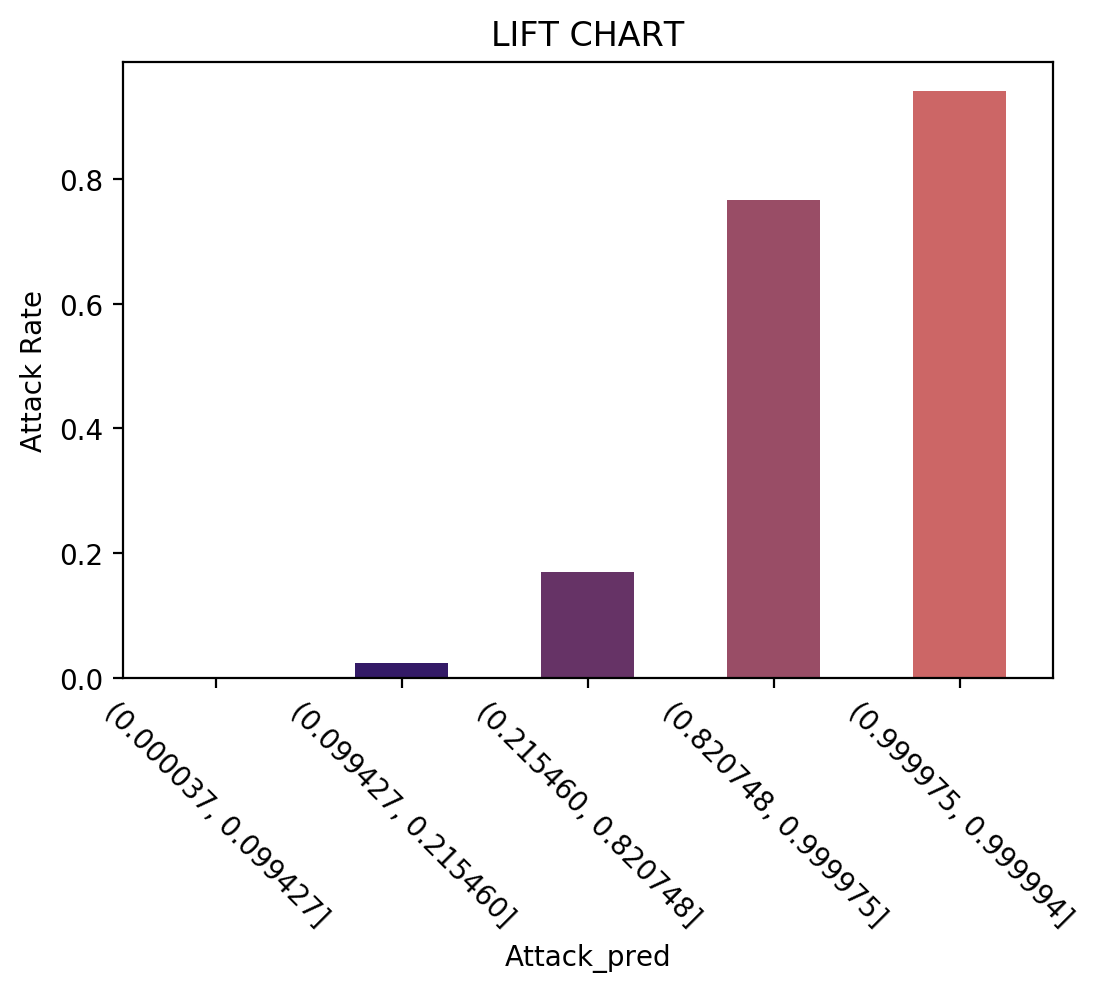

In [172]:
plot_lift(grupos)

## Tuning XGB

In [173]:
x_train_opt = pd.concat([x_train_pca, df_km], axis=1)
x_test_opt = pd.concat([x_test_pca, df_km_test], axis=1)

In [178]:
gridsearch_params = [(max_depth, min_child_weight)
                    for max_depth in range(9,12)
                    for min_child_weight in range(5,8)]

max_auc = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params_xgb['max_depth'] = max_depth
    params_xgb['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params_xgb,
        xgb.DMatrix(x_train_opt, label=y_train),
        num_boost_round=5000,
        seed=0,
        nfold=5,
        metrics='auc',
        early_stopping_rounds=10
    )

    # Update best auc
    mean_auc = cv_results['test-auc-mean'].min()
    boost_rounds = len(cv_results['test-auc-mean'])
    print("\t auc {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth, min_child_weight)
        best_rounds = boost_rounds

print("Best params: {}, {}, auc: {}, rounds: {}".format(best_params[0], best_params[1], min_auc, best_rounds))

CV with max_depth=9, min_child_weight=5
	 auc 0.9990848 for 84 rounds
CV with max_depth=9, min_child_weight=6
	 auc 0.9990822 for 38 rounds
CV with max_depth=9, min_child_weight=7
	 auc 0.9990816 for 44 rounds
CV with max_depth=10, min_child_weight=5
	 auc 0.9991238 for 60 rounds
CV with max_depth=10, min_child_weight=6
	 auc 0.9991204 for 86 rounds
CV with max_depth=10, min_child_weight=7
	 auc 0.9991196 for 60 rounds
CV with max_depth=11, min_child_weight=5
	 auc 0.9991396 for 63 rounds
CV with max_depth=11, min_child_weight=6
	 auc 0.9991346 for 41 rounds
CV with max_depth=11, min_child_weight=7
	 auc 0.9991336 for 39 rounds
Best params: 9, 7, auc: 0.9990816, rounds: 44


In [185]:
params_xgb['max_depth'] = 11
params_xgb['min_child_weight'] = 5

In [186]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

max_auc = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample_bytree={}".format(
                             subsample,
                             colsample))

    # We update our parameters
    params_xgb['subsample'] = subsample
    params_xgb['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params_xgb,
        xgb.DMatrix(x_train_opt, label=y_train),
        num_boost_round=5000,
        seed=0,
        nfold=5,
        metrics='auc',
        early_stopping_rounds=10
    )

    # Update best auc
    mean_auc = cv_results['test-auc-mean'].min()
    boost_rounds = len(cv_results['test-auc-mean'])
    print("\tauc {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample, colsample)
        best_rounds = boost_rounds

print("Best params: {}, {}, auc: {}, rounds: {}".format(best_params[0], best_params[1], max_auc, best_rounds))

CV with subsample=1.0, colsample_bytree=1.0
	auc 0.9991396 for 63 rounds
CV with subsample=1.0, colsample_bytree=0.9
	auc 0.99914 for 99 rounds
CV with subsample=1.0, colsample_bytree=0.8
	auc 0.9991208 for 85 rounds
CV with subsample=1.0, colsample_bytree=0.7
	auc 0.9990966 for 72 rounds
CV with subsample=0.9, colsample_bytree=1.0
	auc 0.9991808 for 76 rounds
CV with subsample=0.9, colsample_bytree=0.9
	auc 0.9991404 for 71 rounds
CV with subsample=0.9, colsample_bytree=0.8
	auc 0.9986996 for 65 rounds
CV with subsample=0.9, colsample_bytree=0.7
	auc 0.998677 for 62 rounds
CV with subsample=0.8, colsample_bytree=1.0
	auc 0.999108 for 75 rounds
CV with subsample=0.8, colsample_bytree=0.9
	auc 0.9991608 for 83 rounds
CV with subsample=0.8, colsample_bytree=0.8
	auc 0.9986542 for 83 rounds
CV with subsample=0.8, colsample_bytree=0.7
	auc 0.9981224 for 54 rounds
CV with subsample=0.7, colsample_bytree=1.0
	auc 0.99911 for 44 rounds
CV with subsample=0.7, colsample_bytree=0.9
	auc 0.998922

TypeError: 'NoneType' object has no attribute '__getitem__'

In [187]:
params_xgb['subsample'] = 0.9
params_xgb['colsample_bytree'] = 1.0

In [189]:
max_auc = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

    # We update our parameters
    params_xgb['eta'] = eta
    
    cv_results = xgb.cv(
        params_xgb,
        xgb.DMatrix(x_train_opt, label=y_train),
        num_boost_round=5000,
        seed=0,
        nfold=5,
        metrics='auc',
        early_stopping_rounds=10
    )

    # Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = len(cv_results['test-auc-mean'])
    print("\tauc {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = eta
        best_rounds = boost_rounds

print("Best params: {}, auc: {}, rounds: {}".format(best_params, max_auc, best_rounds))

CV with eta=0.3
	auc 0.9999584 for 76 rounds
CV with eta=0.2
	auc 0.9999584 for 84 rounds
CV with eta=0.1
	auc 0.9999578 for 144 rounds
CV with eta=0.05
	auc 0.9999248 for 117 rounds
CV with eta=0.01
	auc 0.9998666 for 149 rounds
CV with eta=0.005
	auc 0.9998466 for 144 rounds
Best params: None, auc: inf, rounds: 84


In [190]:
params_xgb['eta'] = 0.2

In [217]:
params_xgb_opt = {'colsample_bytree': 1.0,
             'eta': 0.3,
             'eval_metric': 'auc',
             'max_depth': 11,
             'min_child_weight': 5,
             'objective': 'binary:logistic',
             'subsample': 0.9}

In [218]:
xgb_model_opt = xgb.train(
                    params_xgb_opt,
                    xgb.DMatrix(x_train_opt, label=y_train), 
                    num_boost_round=84
)

In [222]:
xgb_pred_opt = xgb_model_opt.predict(xgb.DMatrix(x_test_opt))

yval = pd.DataFrame(y_test)
yval['Attack_pred'] = xgb_pred_opt
sortvals = yval.sort_values(['Attack_pred'], ascending=True)
rango_deciles = pd.qcut(sortvals['Attack_pred'].rank(method='first'), 5)
grupos = yval.groupby(rango_deciles)['type_attack'].agg([sum, len, np.mean])

In [219]:
xgb_pred_opt = xgb_model_opt.predict(xgb.DMatrix(x_test_opt))

In [223]:
grupos

,sum,len,mean
Attack_pred,,,
"(0.999, 15459.0]",353,15459,0.022835
"(15459.0, 30917.0]",1004,15458,0.064950
"(30917.0, 46375.0]",1488,15458,0.096261
"(46375.0, 61833.0]",11889,15458,0.769116
"(61833.0, 77291.0]",14644,15458,0.947341


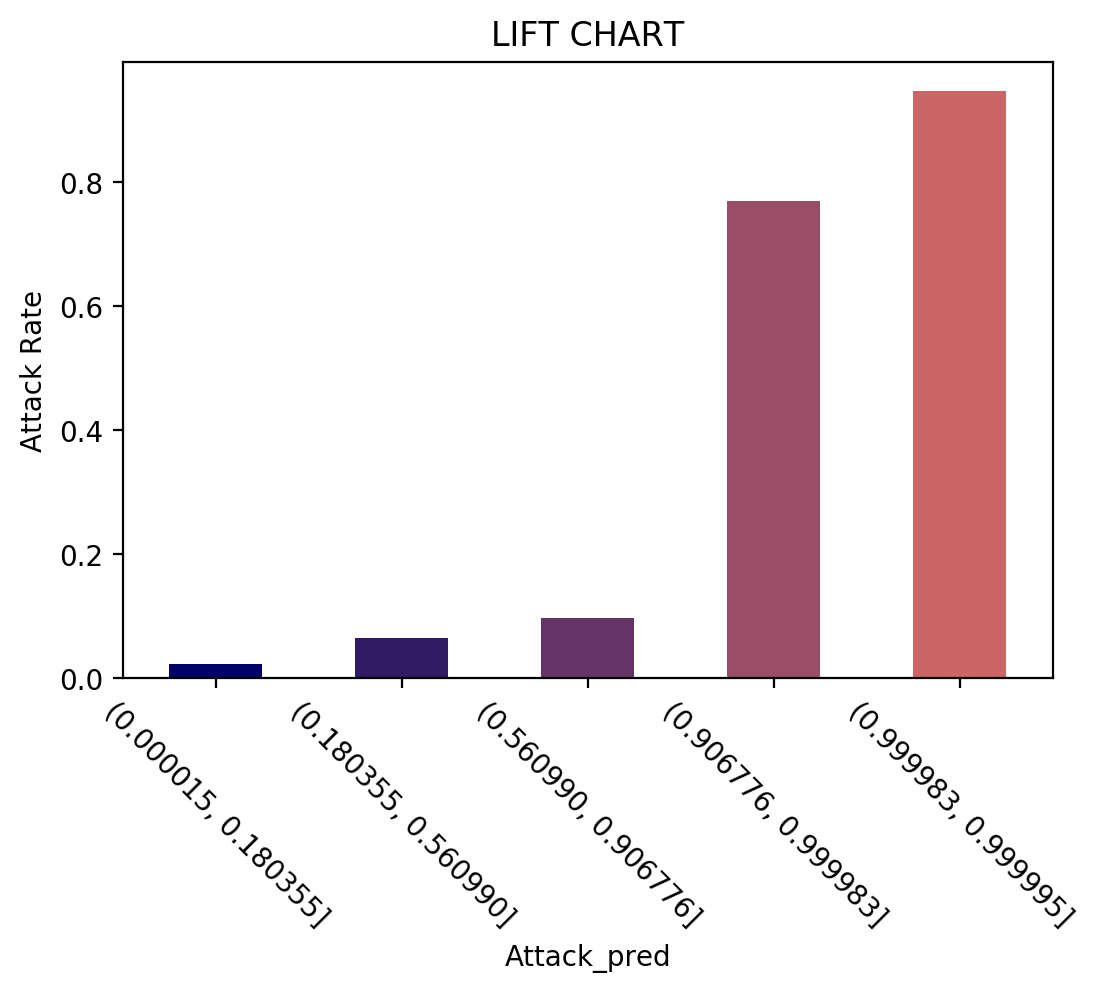

In [224]:
get_ranges(grupos)
plot_lift(grupos)

In [225]:
grupos

,sum,len,mean,ranges
Attack_pred,,,,
"(0.999, 15459.0]",353,15459,0.022835,"(0.000015, 0.180355]"
"(15459.0, 30917.0]",1004,15458,0.064950,"(0.180355, 0.560990]"
"(30917.0, 46375.0]",1488,15458,0.096261,"(0.560990, 0.906776]"
"(46375.0, 61833.0]",11889,15458,0.769116,"(0.906776, 0.999983]"
"(61833.0, 77291.0]",14644,15458,0.947341,"(0.999983, 0.999995]"


## LightGBM

In [232]:
params_lgb = {'objective': 'binary',
          'max_depth': 6,
          'learning_rate':.3,
          'max_bin': 200,
          'metric': 'auc'}

lgb_model = lgb.LGBMClassifier(**params_lgb)
lgb_model.fit(x_train_opt, y_train)

lgb_pred = lgb_model.predict_proba(x_test_opt)[:,1]

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.3,
        max_bin=200, max_depth=6, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=10,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

## CAT

In [234]:
params_cat = {
    'depth': 6,
    'learning_rate': .3,
    'iterations': 100,
    'l2_leaf_reg': 3,
    'border_count': 32,
    'od_type': 'Iter',
    'custom_metric': 'AUC'
}
cat_model = CatBoostClassifier(**params_cat)
cat_model.fit(x_train_opt, y_train)

0:	learn: 0.1909565	total: 264ms	remaining: 26.2s
1:	learn: 0.1148168	total: 568ms	remaining: 27.8s
2:	learn: 0.0595331	total: 848ms	remaining: 27.4s
3:	learn: 0.0499557	total: 1.13s	remaining: 27.2s
4:	learn: 0.0410019	total: 1.42s	remaining: 26.9s
5:	learn: 0.0339523	total: 1.68s	remaining: 26.4s
6:	learn: 0.0294272	total: 1.98s	remaining: 26.4s
7:	learn: 0.0273256	total: 2.25s	remaining: 25.9s
8:	learn: 0.0248818	total: 2.54s	remaining: 25.7s
9:	learn: 0.0236796	total: 2.82s	remaining: 25.4s
10:	learn: 0.0224651	total: 3.12s	remaining: 25.3s
11:	learn: 0.0216432	total: 3.38s	remaining: 24.8s
12:	learn: 0.0210956	total: 3.65s	remaining: 24.4s
13:	learn: 0.0203930	total: 3.92s	remaining: 24.1s
14:	learn: 0.0202427	total: 4.21s	remaining: 23.8s
15:	learn: 0.0194256	total: 4.49s	remaining: 23.6s
16:	learn: 0.0187769	total: 4.74s	remaining: 23.1s
17:	learn: 0.0184518	total: 5s	remaining: 22.8s
18:	learn: 0.0179151	total: 5.27s	remaining: 22.5s
19:	learn: 0.0175761	total: 5.56s	remaining:

In [236]:
cat_pred = cat_model.predict_proba(x_test_opt)[:,1]

## Stacking 

In [205]:
# Stacking

from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

X, y, X_submission = x_train_opt, y_train, x_test_opt

clfs = [XGBClassifier(
            learning_rate=0.2,
            n_estimators=84,
            max_depth=11,
            min_child_weight=5,
            subsample=0.9,
            colsample_bytree=1,
            objective='binary:logistic',
            nthread=-1,
            seed=0
        ),
        LGBMClassifier(objective='binary', learning_rate=0.3, n_estimators=10, 
                       random_state=0, max_bin=200, metric='auc'
        ),
        CatBoostClassifier(verbose=False, learning_rate=0.3, depth=6, iterations=100, random_seed=0, 
                           custom_metric='AUC')
]

print "Creating train and test sets for blending."

dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_submission.shape[0], len(clfs)))

skf = StratifiedKFold(y, 5, random_state=0)

for j, clf in enumerate(clfs):
    print 'Model {0} : {1}'.format(j, clf)
    dataset_blend_test_j = np.zeros((X_submission.shape[0], len(skf)))
    for i, (train, test) in enumerate(skf):
        print "Fold", i
        X_train = X.iloc[train]
        Y_train = y.iloc[train]
        X_test = X.iloc[test]
        Y_test = y.iloc[test]
        if j == 0:
            clf.fit(X_train, Y_train, eval_metric='auc')
            y_submission = clf.predict_proba(X_test)[:, 1]
        elif j == 1:
            clf.fit(X_train, Y_train)
            y_submission = clf.predict_proba(X_test)[:, 1]
        else:
            clf.fit(X_train, Y_train, logging_level='Silent')
            y_submission = clf.predict_proba(X_test)[:, 1]
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict_proba(X_submission)[:, 1]
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)

C:\Users\JERSON\Anaconda2\lib\site-packages\catboost\core.py:1249: FutureWarning: The 'verbose' parameter is deprecated, use 'logging_level' parameter instead (posible values: 'Silent', 'Verbose', 'Info', 'Debug').
  super(CatBoostClassifier, self).__init__(params)


Creating train and test sets for blending.
Model 0 : XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=11,
       min_child_weight=5, missing=None, n_estimators=84, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)
Fold 0


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=11,
       min_child_weight=5, missing=None, n_estimators=84, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

Fold 1


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=11,
       min_child_weight=5, missing=None, n_estimators=84, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

Fold 2


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=11,
       min_child_weight=5, missing=None, n_estimators=84, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

Fold 3


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=11,
       min_child_weight=5, missing=None, n_estimators=84, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

Fold 4


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=11,
       min_child_weight=5, missing=None, n_estimators=84, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

Model 1 : LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.3,
        max_bin=200, max_depth=-1, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=10,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)
Fold 0


C:\Users\JERSON\Anaconda2\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.3,
        max_bin=200, max_depth=-1, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=10,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

Fold 1


LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.3,
        max_bin=200, max_depth=-1, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=10,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

Fold 2


LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.3,
        max_bin=200, max_depth=-1, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=10,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

Fold 3


LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.3,
        max_bin=200, max_depth=-1, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=10,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

Fold 4


LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.3,
        max_bin=200, max_depth=-1, metric='auc', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=10,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

Model 2 : <catboost.core.CatBoostClassifier object at 0x000000003B140400>
Fold 0


Fold 1


Fold 2


Fold 3


Fold 4


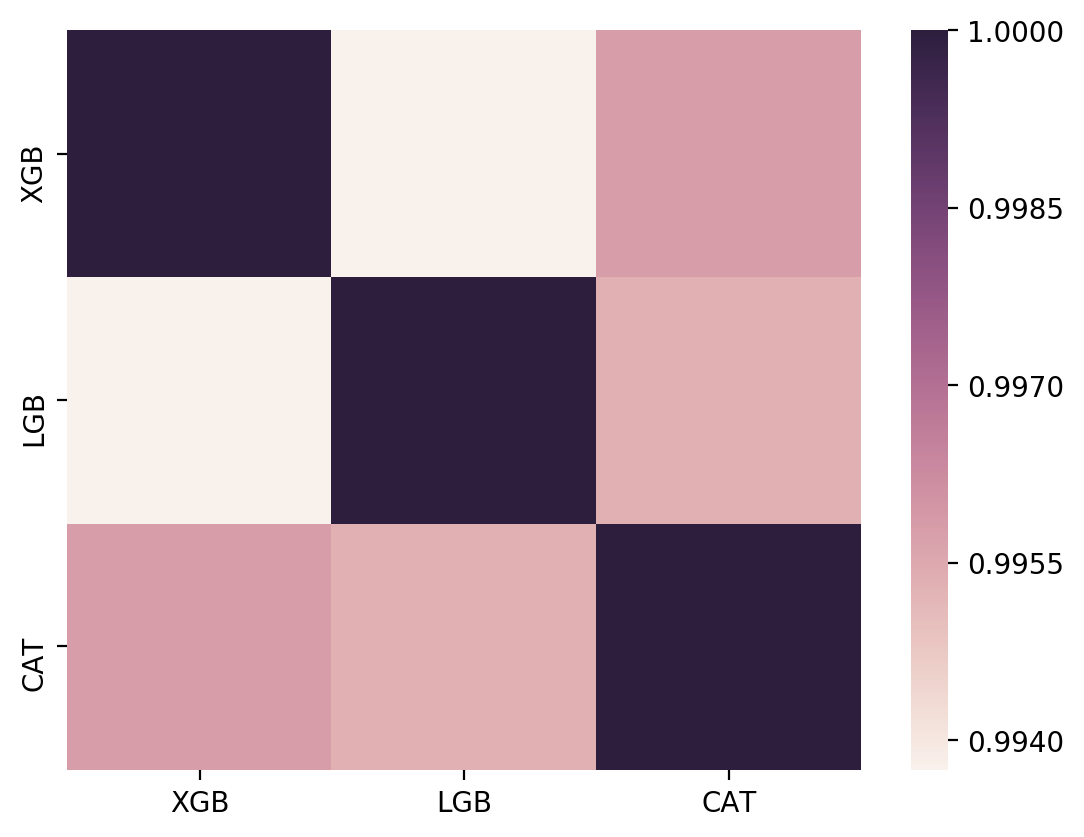

In [206]:
import seaborn as sns
basemodel_pred = pd.DataFrame(data=dataset_blend_train, columns=['XGB', 'LGB', 'CAT'])

sns.heatmap(basemodel_pred.corr())

In [211]:
# tunear parametros
xgb_model_stack = XGBClassifier(objective='binary:logistic', 
                          learning_rate=0.1,
                          seed=0)
xgb_model_stack.fit(dataset_blend_train, y, eval_metric='auc')
y_submission = xgb_model_stack.predict_proba(dataset_blend_test)[:, 1]

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [212]:
metrics.roc_auc_score(y_test, y_submission)

0.94393478765905514

## Averaging

In [230]:
xgb_pred.shape

(77291L,)

In [238]:
lgb_pred.shape

(77291L,)

In [239]:
cat_pred.shape

(77291L,)

In [245]:
avg_pred = np.mean([xgb_pred, lgb_pred, cat_pred], axis=0)

In [253]:
metrics.roc_auc_score(y_test, avg_pred)

0.96822319749994712

In [254]:
pred_opt = avg_pred

yval = pd.DataFrame(y_test)
yval['Attack_pred'] = pred_opt
sortvals = yval.sort_values(['Attack_pred'], ascending=True)
rango_deciles = pd.qcut(sortvals['Attack_pred'].rank(method='first'), 5)
grupos = yval.groupby(rango_deciles)['type_attack'].agg([sum, len, np.mean])

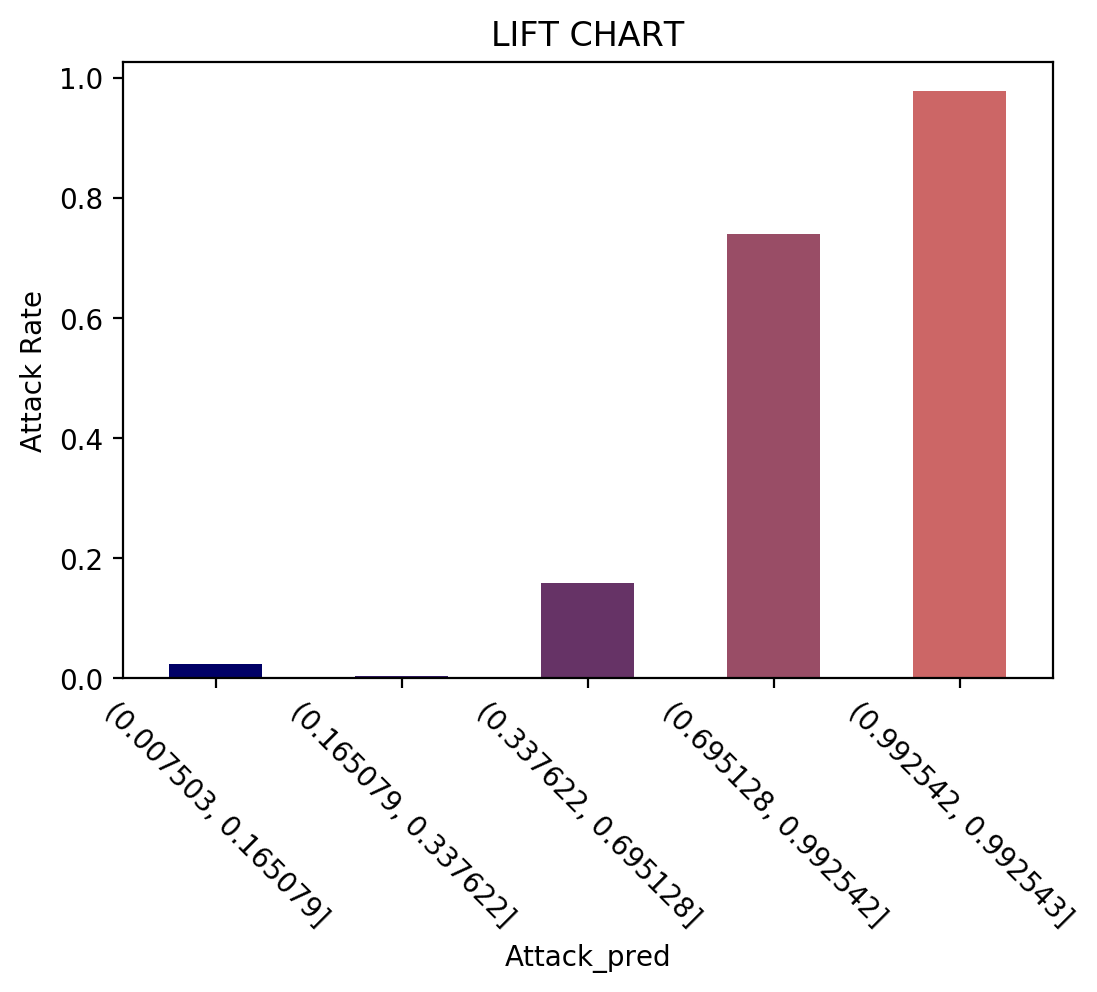

In [255]:
get_ranges(grupos)
plot_lift(grupos)

In [256]:
grupos

,sum,len,mean,ranges
Attack_pred,,,,
"(0.999, 15459.0]",343,15459,0.022188,"(0.007503, 0.165079]"
"(15459.0, 30917.0]",37,15458,0.002394,"(0.165079, 0.337622]"
"(30917.0, 46375.0]",2449,15458,0.158429,"(0.337622, 0.695128]"
"(46375.0, 61833.0]",11441,15458,0.740135,"(0.695128, 0.992542]"
"(61833.0, 77291.0]",15108,15458,0.977358,"(0.992542, 0.992543]"
